## Note
I use the same premise of work as the previous experiment and the same steps.
The model below is actually different because to delimit our bounding boxes instead of using two coordinates (x, y) and two distances (w, h) I use four coordinates (x1, y1, x2, y2), the first two indicate the corner at the top left and the other two at the corner at the bottom right.

I have also implemented some functions with the purpose of inserting them (in the future) into an external file and recalling them via 'import'. I immediately define them to lighten the reading of the session.

# Object detection in images - work in progress

(tags: CNN, Object detection)

<small>This work was inspired by [Johannes Rieke article on Medium](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) and by [Andrew Ng's Specialization Course on Deep Learning](https://www.coursera.org/specializations/deep-learning).</small>

Rieke's work is interesting for the simplicity with which he creates a trainingset for our purpose - that is, developing bounding boxes that identify particular objects in an image. I dedicate myself in particular to the identification of several objects in the same image.

Rieke highlights a big risk: in the identification of N objects, the neural network ends up with not specializing and instead it develops 'average' bounding boxes - more or less equal - useless for our purpose. To solve this problem he proposes an algorithm for swapping the example's targets label between one epoch and another. A mechanism that did not convince me for two reasons:

- it considerably weighs the algorithm on a computational level (at the end of epoch the predictions of the network with the target values are compared).
- in the tests I did I could not get out of a sort of perpetual oscillation and at every epoch the percentage of swaps remained almost unchanged.

Conceptually starting from the work of Rieke I propose a solution that makes clear the importance of a preprocessing of our dataset. In fact, I create an order in the target values of our trainingset. I take as reference point the distance from one of the edges of the image (the origin in a coordinate system). 

As you can see it is an elegant solution that solves the problem upstream. Later I dedicate myself to improving the efficiency of the neural network.



In [0]:
# We define one of the reference metrics to analyze our results
# the Intersection over Union that measures the correspondence 
# of our predictions with the actual bounding boxes

def IoU(box1, box2):
  '''Intersection over Union (IoU) between box1 and box2
    
  Arguments:
  box1 -- first box, with coordinates (x1, y1, w1, h1)
  box2 -- second box, with coordinates (x2, y2, w2, h2)
  
  Returns:
  iou -- scalar
  '''    
  [x1, y1, w1, h1] = box1
  [x2, y2, w2, h2] = box2
    
  # Intesection area 
  xi1 = np.maximum(x1, x2)
  yi1 = np.maximum(y1, y2)
  xi2 = np.minimum(x1+w1, x2+w2)
  yi2 = np.minimum(y1+h1, y2+h2)
  xi = np.maximum(0., xi2-xi1)
  yi = np.maximum(0., yi2-yi1)
  
  inter_area = np.multiply(xi,yi)

  # Union area
  box1_area = (w1*h1)
  box2_area = (w2*h2)
  union_area = box1_area+box2_area-inter_area
  
  # Calculation of IoU
  iou = inter_area/union_area

  return iou


In [0]:
# We measure the average IoU of the whole test set 
def mean_IoU_c(expe_bboxes, pred_bboxes, dim_test, N_bb):
  expe = expe_bboxes[:,:,1:]
  pred = pred_bboxes[:,:,1:]
 
  IoU_test = np.zeros((dim_test, N_bb)) 
  iou_global = 0
  
  for i in range(dim_test):
    for j in range(N_bb):
      [x, y, x2, y2] = pred[i,j]
      [xe, ye, x2e, y2e] = expe[i,j]
      
      IoU_test[i,j] = IoU([x, y, x2-x, y2-y], [xe, ye, x2e-xe, y2e-ye])

  iou_global = np.mean(IoU_test)
  return iou_global


In [0]:
def visual_metric(train_ex, m_iou, N_ep, Batchs, history, metric):
  print('----> Testset IoU:', m_iou)
  print('      Dim. train:', train_ex, 'examples')
  print('      Epochs:', N_ep, '- mini-batches:', Batchs)

  # Plot training & validation accuracy values
  plt.plot(history[metric])
  plt.plot(history['val_' + metric])
  plt.title('Model ' + metric)
  plt.ylabel(metric)
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input, Activation
from keras import optimizers
import pickle

%matplotlib inline

Using TensorFlow backend.


We create a simple image dataset. Each image will have a maximum size of 32x32 and will contain up to a maximum of N_bb objects (rectangles) with different shades of color. Their size will vary between a minimum of 1x1 and a maximum of 8x8. [To implement : If the color gradation (0-255) is less than or greater than a certain threshold (in our case <64), the object must not be detected.]

At the same time we define our bounding boxes. We will use 5 coordinates: a 'Pc', which indicates the percentage of confidence in the presence of an object; 'x' and 'y', for the spatial position of the top-left vertex and 'w' and 'h' for the extension (width and height).

In [0]:
# number of images in our dataset
N_imgs = 12500

# imagines side dimension
side_dim = 32 # 24

# objects min/max side dimensions
obj_min_dim = 2
obj_max_dim = 8 

# number of objects
N_bb = 4 # 4

# color thresholds
min_threshold = 0
max_threshold = 124

# confidence threshold
Pc_th = .0

# inizialization of images with a light gray color (just for aesthetic reasons)
imgs = np.ones((N_imgs, side_dim, side_dim,3)) * .9 

# inizialization of bounding boxes
bounding_boxes = np.zeros((N_imgs, N_bb, 5))

In [0]:
# inizialization of origin distance array
distance = np.zeros((N_imgs, N_bb))

# creation of objects in images and relative bounding boxes

for N_img in range(N_imgs):
    for i_ogg in range(N_bb):
        w = np.random.randint(obj_min_dim, obj_max_dim)
        h = np.random.randint(obj_min_dim, obj_max_dim)
        x = np.random.randint(0, side_dim - w)
        y = np.random.randint(0, side_dim - h)
        x2= x+w
        y2= y+h
          
        R = (np.random.randint(min_threshold, max_threshold)) / 255
        G = (np.random.randint(min_threshold, max_threshold)) / 255
        B = (np.random.randint(min_threshold, max_threshold)) / 255
        
        imgs[N_img, y:y2, x:x2, 0] = R 
        imgs[N_img, y:y2, x:x2, 1] = G 
        imgs[N_img, y:y2, x:x2, 2] = B 
        

        Pc = 1. # for the moment we use for all target value Pc = 1
        bounding_boxes[N_img, i_ogg] = [Pc, x, y, x2, y2]   
        
        # we calculate the distance from the origin for each Bounding Box
        distance[N_img, i_ogg] = np.sqrt(np.square((x+x2)/2)+ np.square((y+y2)/2))


## Observation and pre-processing
First we analyze our datasets and start preprocessing them

In [7]:
# Let's look at the size of the Numpy arrays for images and bboxes 
print('Dimension of images array:', imgs.shape)
print('Dimension of BBoxes array:', bounding_boxes.shape)
print('Dimension of distance array:', distance.shape)

Dimension of images array: (12500, 32, 32, 3)
Dimension of BBoxes array: (12500, 4, 5)
Dimension of distance array: (12500, 4)


Imagine n. 6009


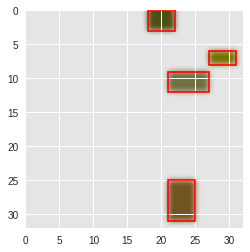

In [8]:
# We take a random image of our training set
im = np.random.randint(N_imgs)
print('Imagine n.', im)

# Let's look the objects contained in it...
fig, ax = plt.subplots(1)
ax.imshow(imgs[im], origin = 'upper', interpolation = 'quadric', extent=[0, side_dim, side_dim, 0])

# ...and the corresponding bounding boxes
for i in range (N_bb):
  [Pc, x, y, x2, y2] = bounding_boxes[im, i]

# we consider only a percentage of confidence above the Pc_th
# (in our datasets we have Pc with values 0 or 1) but later
# Pc will assume probabilistic values between 0 and 1
  if Pc >= Pc_th:
    rect = patches.Rectangle((x, y) , (x2-x), (y2-y), ec='r', lw='1.6', fc='none')
    ax.add_patch(rect)

plt.show()

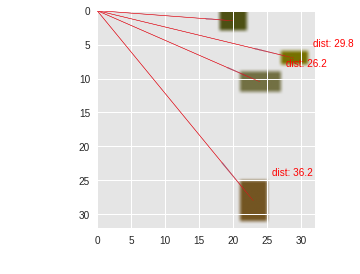

In [9]:
# We look at the image again, this time highlighting the distance of the objects from the origin ...
fig, ax = plt.subplots(1)

ax.imshow(imgs[im], origin = 'upper', interpolation = 'hanning', extent=[0, side_dim, side_dim, 0])

for i in range (N_bb):
  [Pc, x, y, x2, y2] = bounding_boxes[im, i]

  if Pc >= Pc_th:
    line = patches.Arrow(0, 0, (x+x2)/2, (y+y2)/2, .2, ec='r') 
    ax.add_patch(line)
    dida = 'dist: ' + '{:0.1f}'.format(distance[im,i])
    plt.annotate(dida, (x2 + 0.8 , y - 0.8), color='r')

plt.show()

We rearrange the bounding boxes based on the distance from the origin of the objects

In [0]:
order = np.zeros((N_imgs, N_bb), dtype=int)
bboxes = np.zeros(bounding_boxes.shape)

for i in range(N_imgs):
  order[i] = np.argsort(distance[i]) 
  for j in range(N_bb):
    bboxes[i,j] = (bounding_boxes[i, order[i,j]])

### Save Datasets
Now we save our datasets for future uses

In [0]:
dataset_name = str(N_imgs/1000)

In [12]:
# To save datasets
np.save('Images_' + dataset_name, imgs)
np.save('Bboxes_' + dataset_name, bboxes)

# To load datasets
'''
imgs = np.load('Images_' + dataset_name + '.npy')
bboxes = np.load('Bboxes_' + dataset_name + '.npy')
print(imgs.shape, bboxes.shape)

'''

"\nimgs = np.load('Images_' + dataset_name + '.npy')\nbboxes = np.load('Bboxes_' + dataset_name + '.npy')\nprint(imgs.shape, bboxes.shape)\n\n"

Let's start thinking in terms of Machine Learning. 
So we normalize the pixel values contained in our images to have values between -1 and 1 and transfer them to the input X values.

Similarly we normalize the geometric values of our bboxes with respect to the size of the images.

In [13]:
X = (imgs - np.mean(imgs)) / np.std(imgs)
X = np.reshape(X, (N_imgs, side_dim, side_dim, 3))
print(X.shape, np.mean(imgs), np.std(imgs))


Y = np.concatenate((bboxes[:,:, :1], (bboxes[:,:, 1:]/side_dim)), axis=-1)
Y = Y.reshape(N_imgs, -1) 
print(Y.shape)

(12500, 32, 32, 3) 0.8499830046466491 0.1787386004030311
(12500, 20)


Below we see the shape of our X values

In [14]:
print('Images example', i, 'has shape:\n', X[im].shape, '\n')

Images example 12499 has shape:
 (32, 32, 3) 



And then we observe one of our Y target values

In [15]:
print('...and the target values Y are:\n', Y[im])

...and the target values Y are:
 [1.      0.5625  0.      0.6875  0.09375 1.      0.65625 0.28125 0.84375
 0.375   1.      0.84375 0.1875  0.96875 0.25    1.      0.65625 0.78125
 0.78125 0.96875]


We have a homogeneous dataset of the N_imgs elements that we now share in Training set, Validation set, and Test set in relation 80%, 10%, 10%.

In [16]:
i = int(0.8 * N_imgs)
j = int(0.1 * N_imgs)

X_train = X[:i]
Y_train = Y[:i]
train_ex = X_train.shape[0]

X_val = X[i:i+j]
Y_val = Y[i:i+j]
val_ex = X_val.shape[0]

X_test = X[i+j:]
Y_test = Y[i+j:]
test_ex = X_test.shape[0]

dim_test = j # useful for the future 

print('Below the dimensions of X and Y for Training set, Validation set, and Test set respectively\n')
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

Below the dimensions of X and Y for Training set, Validation set, and Test set respectively

(10000, 32, 32, 3) (10000, 20) (1250, 32, 32, 3) (1250, 20) (1250, 32, 32, 3) (1250, 20)


## The Neural Network
Following our DNN model, is inspired by other detection algorithms and uses three pairs of CNN-MaxPooling layers followed by two fully connected layers, for a total of about 460 thousand parameters.

In [17]:
model = Sequential()
model.add(Conv2D(48, kernel_size=(8, 8), strides=2, padding='same', activation='relu', input_shape=(side_dim,side_dim,3), data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(Conv2D(96, kernel_size=(4, 4), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(Conv2D(192, kernel_size=(2, 2), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(Flatten())
model.add(Dropout(.4))
model.add(Dense(384, activation='relu'))
model.add(Dropout(.4))
model.add(Dense(Y.shape[-1]))

summ = model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 48)        9264      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 48)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 96)          73824     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 192)         73920     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 192)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 768)               0         
__________

At least for the moment we do not worry too much about the efficiency of the loss function and the optimization algorithm. We use the Mean Squared Error for the first and Adadelta for the second.

Let's start with a cycle of N_ep epochs:

In [0]:
N_ep = 100
init_ep = 0 
Batchs = 16
optimizer = 'adadelta'
loss = 'mse'

In [20]:
model.compile(optimizer, loss)
history = model.fit(X_train, Y_train, epochs=N_ep, validation_data=(X_val, Y_val), batch_size=Batchs, initial_epoch = init_ep, verbose=1)

Train on 10000 samples, validate on 1250 samples
Epoch 1/100
10000/10000 [==============================] - 11s 1ms/step - loss: 0.0412 - val_loss: 0.0230
Epoch 2/100
10000/10000 [==============================] - 6s 647us/step - loss: 0.0234 - val_loss: 0.0177
Epoch 3/100
10000/10000 [==============================] - 7s 654us/step - loss: 0.0198 - val_loss: 0.0161
Epoch 4/100
10000/10000 [==============================] - 6s 649us/step - loss: 0.0180 - val_loss: 0.0152
Epoch 5/100
10000/10000 [==============================] - 7s 651us/step - loss: 0.0167 - val_loss: 0.0144
Epoch 6/100
10000/10000 [==============================] - 7s 652us/step - loss: 0.0157 - val_loss: 0.0145
Epoch 7/100
10000/10000 [==============================] - 6s 649us/step - loss: 0.0149 - val_loss: 0.0137
Epoch 8/100
10000/10000 [==============================] - 6s 648us/step - loss: 0.0141 - val_loss: 0.0127
Epoch 9/100
10000/10000 [==============================] - 7s 651us/step - loss: 0.0135 - val_lo

We save our model structure, weight and training history for future evaluetions. We will have three file: a json for the model, an h5 for weights and _hist to memorize our training history. 

In [0]:
# Name will contains name of the model (m2), number of X examples in thousands (10), mini-batches (128), epochs (5)

name = 'm2_x' + str(int(train_ex/1000)) + '_mb' + str(Batchs) + '_e' + str(N_ep)
model_name = name + '.json' 
weight_name = name + '.h5'
train_history = name + '_hist'

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open(model_name, 'w') as json_file:
    json_file.write(model_json)

In [23]:
# serialize weights to HDF5
model.save_weights(weight_name)
print('Saved model to disk')

# save just history
with open(train_history, 'wb') as hist:
  pickle.dump(history, hist)

Saved model to disk


##Observation of results
We evaluate the results obtained. We use the Test Set for predictions and define a metric, the IoU (Intersection over Union) that supports those we already have for the training phase - loss error.

The Intersection over Union is an incredibly effective measure to understand how much our forecasts approach the correct bounding boxes of the objects in the images. It has values that oscillate between 0 and 1 and the closer they are to 1, the more the area of our predictions approaches that of the correct bounding boxes.

But first let's take a look at our predictions.

In [24]:
# The predictions of the neural network using our Test set as input
pred_bboxes = model.predict(X_test)
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), N_bb, -1)
pred_bboxes.shape

(1250, 4, 5)

In [25]:
expe_bboxes = Y_test.reshape(dim_test, N_bb, -1)
pred_bboxes.shape, expe_bboxes.shape

((1250, 4, 5), (1250, 4, 5))

Test images: 1244
Object:  1
B-box confidence: 1.000663
B-box coordinates: [2.90 2.09 7.12 6.49]
Object coordinates: [2. 1. 5. 6.]
Test images: 1244
Object:  2
B-box confidence: 1.0002064
B-box coordinates: [2.21 11.12 6.37 15.75]
Object coordinates: [ 3. 12.  6. 17.]
Test images: 1244
Object:  3
B-box confidence: 1.0001315
B-box coordinates: [22.23 2.08 26.56 6.41]
Object coordinates: [21.  1. 28.  5.]
Test images: 1244
Object:  4
B-box confidence: 1.0007739
B-box coordinates: [19.71 23.93 24.35 28.42]
Object coordinates: [19. 23. 25. 29.]


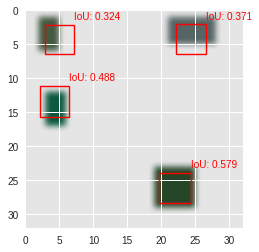

In [26]:
imgTest = (np.reshape(X_test, (dim_test, side_dim, side_dim, 3)) * np.std(imgs)) + np.mean(imgs)

# Consider a random image of our Test set
im = np.random.randint(dim_test)

# We look at the objects contained in it...
fig, ax = plt.subplots(1)
ax.imshow(imgTest[im], origin = 'upper', interpolation = 'quadric', extent=[0, side_dim, side_dim, 0])

# ...and the bounding boxes predicted by the algorithm
for i in range (N_bb):
  [x , y, x2, y2] = pred_bboxes[im, i, 1:] * side_dim
  Pc = pred_bboxes[im,i,0]

  expected_box = expe_bboxes[im, i, 1:] * side_dim 
  [eB_x, eB_y, eB_x2, eB_x1] = expected_box
  
  rect = patches.Rectangle((x, y) , (x2-x), (y2-y), ec='r', lw='1.4', fc='none')

  dida = 'IoU: ' + '{:0.3f}'.format(IoU([x,y,(x2-x),(y2-y)], [eB_x, eB_y, (eB_x2-eB_x), (eB_x1-eB_y)]))
  plt.annotate(dida, (x2 , y - 0.8), color='r')

  print('Test images:', im)
  print('Object: ', i+1)
  print('B-box confidence:', Pc)
  print('B-box coordinates:', '[{:0.2f}'.format(x), '{:0.2f}'.format(y), '{:0.2f}'.format(x2), '{:0.2f}]'.format(y2))
  print('Object coordinates:', expected_box)

  ax.add_patch(rect)

plt.show()


Test images: 559
Object:  1
B-box confidence: 1.000937
B-box coordinates: [6.24 7.81 10.52 12.35]
Object coordinates: [ 5.  9. 11. 13.]
Test images: 559
Object:  2
B-box confidence: 1.0008702
B-box coordinates: [18.54 6.92 22.92 11.49]
Object coordinates: [22.  5. 28.  8.]
Test images: 559
Object:  3
B-box confidence: 1.0005263
B-box coordinates: [4.11 26.75 8.45 31.06]
Object coordinates: [ 4. 24. 10. 31.]
Test images: 559
Object:  4
B-box confidence: 1.0000352
B-box coordinates: [24.01 22.95 28.50 27.28]
Object coordinates: [27. 25. 29. 27.]


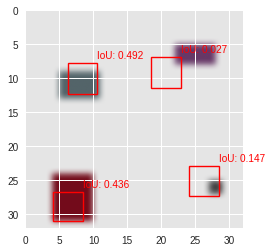

In [36]:
imgTest = (np.reshape(X_test, (dim_test, side_dim, side_dim, 3)) * np.std(imgs)) + np.mean(imgs)

# Consider a random image of our Test set
im = np.random.randint(dim_test)

# We look at the objects contained in it...
fig, ax = plt.subplots(1)
ax.imshow(imgTest[im], origin = 'upper', interpolation = 'quadric', extent=[0, side_dim, side_dim, 0])

# ...and the bounding boxes predicted by the algorithm
for i in range (N_bb):
  [x , y, x2, y2] = pred_bboxes[im, i, 1:] * side_dim
  Pc = pred_bboxes[im,i,0]

  expected_box = expe_bboxes[im, i, 1:] * side_dim 
  [eB_x, eB_y, eB_x2, eB_x1] = expected_box
  
  rect = patches.Rectangle((x, y) , (x2-x), (y2-y), ec='r', lw='1.4', fc='none')

  dida = 'IoU: ' + '{:0.3f}'.format(IoU([x,y,(x2-x),(y2-y)], [eB_x, eB_y, (eB_x2-eB_x), (eB_x1-eB_y)]))
  plt.annotate(dida, (x2 , y - 0.8), color='r')

  print('Test images:', im)
  print('Object: ', i+1)
  print('B-box confidence:', Pc)
  print('B-box coordinates:', '[{:0.2f}'.format(x), '{:0.2f}'.format(y), '{:0.2f}'.format(x2), '{:0.2f}]'.format(y2))
  print('Object coordinates:', expected_box)

  ax.add_patch(rect)

plt.show()


### Evaluation of results
Now we evaluate the results, by calculating the average IoU for predictions on our Test set. 
The graph below shows the learning curve (loss training / validation) for three hundred epochs, with a network of 10 thousand images (use of mini-batch size 16).

----> Testset IoU: 0.2624476321430301
      Dim. train: 10000 examples
      Epochs: 100 - mini-batches: 16


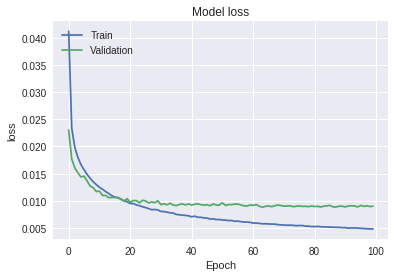

In [33]:
m_iou = mean_IoU_c(expe_bboxes, pred_bboxes, dim_test, N_bb)
visual_metric(train_ex, m_iou, N_ep, Batchs, history.history, 'loss')

## Some conclusion
Compared to the previous experiment, we observe that the loss of the Validation-set reaches the plateau already after the 20th age. Its values are substantially higher than those of the other experiment. Nevertheless the IoU is better than the one obtained with the model (x, y, w, h).

### Another Experiment
Here is another experiment carried out with a dataset of 10 thousand examples, but with mini batchs of size 128 instead of 16. The experiment was carried out for 500 epochs. We also see a cross-section of the various phases of the training, with the value of the IoU for the Test-set at each epoch.

----> Testset IoU: 0.2522054117635771
      Dim. train: 10000 examples
      Epochs: 500 - mini-batches: 128


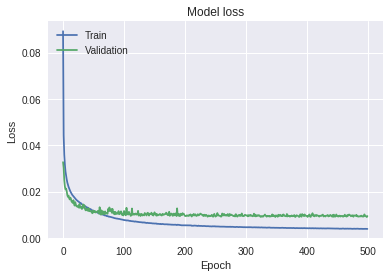

In [153]:
m_iou = mean_IoU_c(expe_bboxes, pred_bboxes, dim_test, N_bb)
visual_metric(train_ex, m_iou, 500, Batchs, history, 'Loss')

In the following graphs I report the trend of the same curve made in pieces, showing the value of the IOU (the metric to which we hold more) after 5, 10, 20, 60, 100, 150, 200 and 300 epochs.

----> Testset IoU: 0.07514584146733548
      Dim. train: 10000 examples
      Epochs: 5 - mini-batches: 128


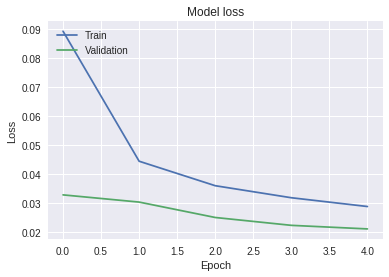

In [97]:
m_iou = mean_IoU_c(expe_bboxes, pred_bboxes, dim_test, N_bb)
visual_metric(train_ex, m_iou, 5, Batchs, history, 'Loss')

----> Testset IoU: 0.09048132569799283
      Dim. train: 10000 examples
      Epochs: 10 - mini-batches: 128


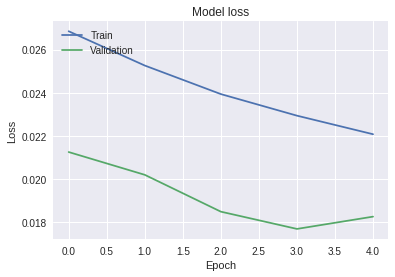

In [102]:
m_iou = mean_IoU_c(expe_bboxes, pred_bboxes, dim_test, N_bb)
visual_metric(train_ex, m_iou, 10, Batchs, history, 'Loss')

----> Testset IoU: 0.1568599733805683
      Dim. train: 10000 examples
      Epochs: 20 - mini-batches: 128


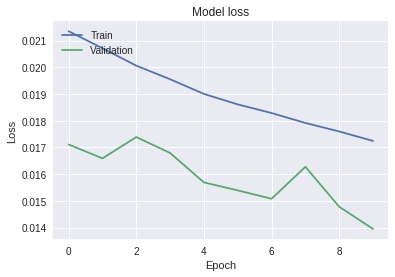

In [106]:
m_iou = mean_IoU_c(expe_bboxes, pred_bboxes, dim_test, N_bb)
visual_metric(train_ex, m_iou, 20, Batchs, history, 'Loss')

----> Testset IoU: 0.15917990612348945
      Dim. train: 10000 examples
      Epochs: 30 - mini-batches: 128


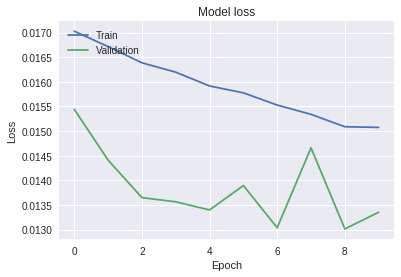

In [110]:
m_iou = mean_IoU_c(expe_bboxes, pred_bboxes, dim_test, N_bb)
visual_metric(train_ex, m_iou, 30, Batchs, history, 'Loss')

----> Testset IoU: 0.19564341430768786
      Dim. train: 10000 examples
      Epochs: 60 - mini-batches: 128


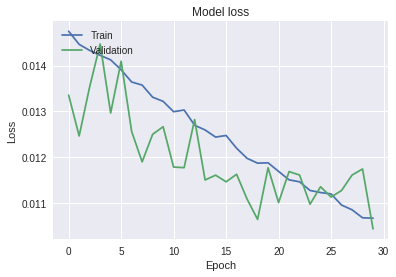

In [118]:
m_iou = mean_IoU_c(expe_bboxes, pred_bboxes, dim_test, N_bb)
visual_metric(train_ex, m_iou, 60, Batchs, history, 'Loss')

----> Testset IoU: 0.21391217739049107
      Dim. train: 10000 examples
      Epochs: 100 - mini-batches: 128


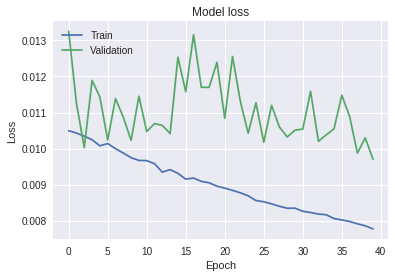

In [126]:
m_iou = mean_IoU_c(expe_bboxes, pred_bboxes, dim_test, N_bb)
visual_metric(train_ex, m_iou, 100, Batchs, history, 'Loss')

----> Testset IoU: 0.21839030930491704
      Dim. train: 10000 examples
      Epochs: 150 - mini-batches: 128


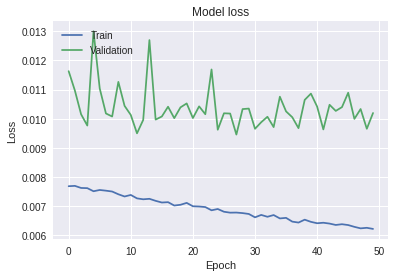

In [31]:
m_iou = mean_IoU_c(expe_bboxes, pred_bboxes, dim_test, N_bb)
visual_metric(train_ex, m_iou, 150, Batchs, history, 'Loss')

----> Testset IoU: 0.22660425729028158
      Dim. train: 10000 examples
      Epochs: 200 - mini-batches: 128


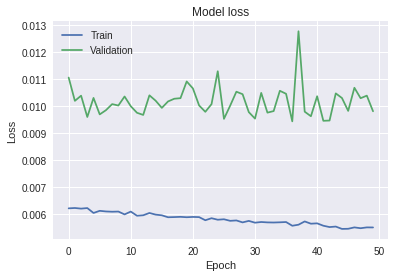

In [54]:
m_iou = mean_IoU_c(expe_bboxes, pred_bboxes, dim_test, N_bb)
visual_metric(train_ex, m_iou, 200, Batchs, history, 'Loss')

----> Testset IoU: 0.23682644149494386
      Dim. train: 10000 examples
      Epochs: 300 - mini-batches: 128


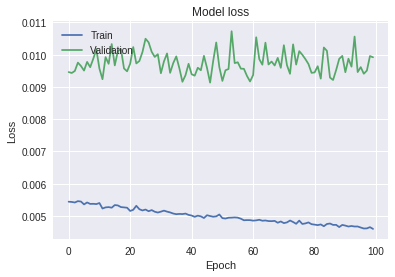

In [48]:
m_iou = mean_IoU_c(expe_bboxes, pred_bboxes, dim_test, N_bb)
visual_metric(train_ex, m_iou, 300, Batchs, history, 'Loss')

----> Testset IoU: 0.2522054117635771
      Dim. train: 10000 examples
      Epochs: 500 - mini-batches: 128


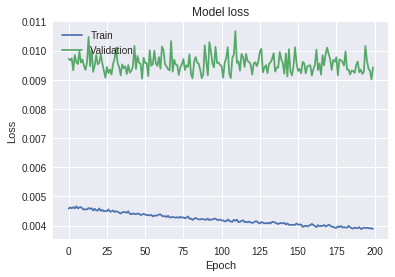

In [145]:
m_iou = mean_IoU_c(expe_bboxes, pred_bboxes, dim_test, N_bb)
visual_metric(train_ex, m_iou, 500, Batchs, history.history, 'Loss')

An interesting thing that we notice is that after the 200 epochs even when the loss of the validation-set no longer seems to improve, the IoU continues to grow even if only slightly. But even so, a model with mini-batch with size of 16 works better. In 100 epochs gives better results than 500 epochs with 128 size mini-batch. 